# Model finding

This notebook will work finding the best model to make predictions on our datas 

**Main goals are**: 
- Find or more suitable models
- Tune their parameters to improve their performances
- Evaluate their performance using different metrics

In [1]:
# Retreiving a significative amount of data
from local_lib.dataset import retreiveDatasetFromCsv

dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

**Image retreiving was created due to memory problem, since it is solved by reducing csv shape it is not necessary anymore**

In [93]:
# Retreiving a significative amount of data
# from local_lib.dataset_images import retreiveDatasetFromImages

# dataset = retreiveDatasetFromImages(500)

In [2]:
dataset.iloc[0]["pixel_value"]

array([35, 37, 38, ..., 27, 28, 27], dtype=int64)

**We use a custom flatten mask to make our data compatible with machine learning models**

In [2]:
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([
    ('image_mask', FlattenTransformer()),
])

# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

In [3]:
import numpy as np
np.shape(X)

(5856, 35860)

In [4]:
np.unique(y)

array([0, 1, 2])

### First we restrict predicted data to 2 classes

In [3]:
import copy

# Make a copy of the list
y_simpler = copy.deepcopy(y)
y_simpler[y_simpler == 2] = 1
np.unique(y_simpler)

array([0, 1])

In [6]:
from sklearn.model_selection import train_test_split
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X, y_simpler, test_size=0.33, random_state=0)

In [18]:
import numpy as np

# First of all we will use a DummyClassifier to get an idea of what a uncorrelated model looks like
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_simple, y_train_simple)
ac = dummy_clf.score(X_test_simple, y_test_simple)
print("Using randomly generated answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_simple, y_train_simple)
ac = round(dummy_clf.score(X_test_simple, y_test_simple) * 100, 2)
print("Using only most frequent number as answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train_simple, y_train_simple)
ac = round(dummy_clf.score(X_test_simple, y_test_simple) * 100, 2)
print("Using uniform distribution answer we get " + str(ac) + "% Accuracy")

Using randomly generated answer we get 0.5990688049663735% Accuracy
Using only most frequent number as answer we get 72.79% Accuracy
Using uniform distribution answer we get 48.94% Accuracy


**We can consider a <72.79% accuracy as irrelevent**

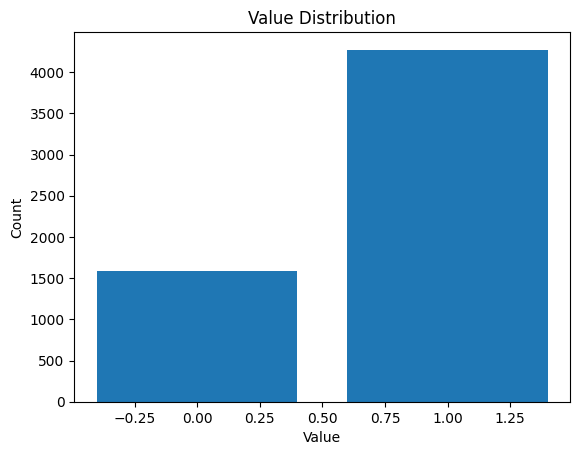

In [19]:
import matplotlib.pyplot as plt
unique_values, counts = np.unique(y_simpler, return_counts=True)

# Plot the bar chart
plt.bar(unique_values, counts)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Value Distribution')
plt.show()

**Uneven data distribution, we will generate more sample later but we stick with it for now**

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='none')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train_simple, y_train_simple)
accTrain = round(pipeline.score(X_train_simple, y_train_simple) * 100, 2)
accTest = round(pipeline.score(X_test_simple, y_test_simple) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 93.5% Accuracy - [TrainSet]
Combined mask accuracy is around 91.88% Accuracy - [TestSet]


Confusion matrix:
[[ 395  131]
 [  26 1381]]


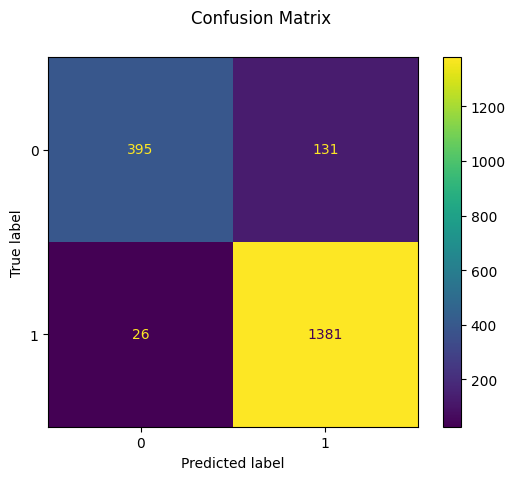

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_simpler = pipeline.predict(X_test_simple)
disp = ConfusionMatrixDisplay.from_predictions(y_test_simple, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score

# Make predictions on the test set
pipeline.fit(X_train_simple, y_train_simple)
y_pred = pipeline.predict(X_test_simple)

# Calculate precision and recall
precision = precision_score(y_test_simple, y_pred)
recall = recall_score(y_test_simple, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9133597883597884
Recall: 0.9815209665955935


### Very important : 
 - We volontary insist on recall value cause it represent false positive and is very dangerous in medical application
 - So for now we will prefer a slightly lower accurate model that prevent false positive
 - Still pretty accurate for a raw model

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  GridSearchCV
from local_lib.testerTransformer import TesterTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
            'image_mask__strategy': ["combined", "geometry", "baseline", "none"]
            }

grid_search = GridSearchCV(
                    pipeline,
                    param_grid=param_grid,
                    cv=5,
                    return_train_score=True,
                    scoring='recall').fit(X_train_simple, y_train_simple)

grid_search.best_params_

{'image_mask__strategy': 'combined'}

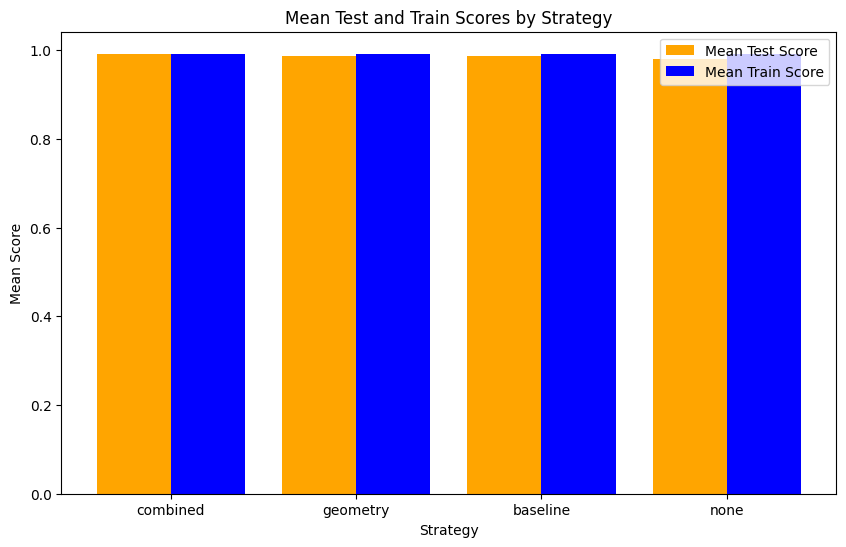

In [54]:
# Calculate mean test and train scores for each split
mean_test_scores = [np.mean(grid_search.cv_results_[f'split{i}_test_score']) for i in range(4)]
mean_train_scores = [np.mean(grid_search.cv_results_[f'split{i}_train_score']) for i in range(4)]

# Strategy names
strategies = grid_search.cv_results_['param_image_mask__strategy']

# Plot bar chart for mean scores
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(strategies)) - 0.2, mean_test_scores, width=0.4, label='Mean Test Score', color='orange')
plt.bar(np.arange(len(strategies)) + 0.2, mean_train_scores, width=0.4, label='Mean Train Score', color='blue')
plt.xticks(np.arange(len(strategies)), strategies)
plt.xlabel('Strategy')
plt.ylabel('Mean Score')
plt.title('Mean Test and Train Scores by Strategy')
plt.legend()
plt.show()

In [44]:
grid_search.cv_results_

{'mean_fit_time': array([1.42168927, 1.88773212, 1.71419744, 1.29741879]),
 'std_fit_time': array([0.1701405 , 0.54315034, 0.13183713, 0.07300441]),
 'mean_score_time': array([1.98566413, 2.66613345, 2.71712255, 1.97596021]),
 'std_score_time': array([0.10974703, 0.74489436, 0.30947629, 0.02623358]),
 'param_image_mask__strategy': masked_array(data=['combined', 'geometry', 'baseline', 'none'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'image_mask__strategy': 'combined'},
  {'image_mask__strategy': 'geometry'},
  {'image_mask__strategy': 'baseline'},
  {'image_mask__strategy': 'none'}],
 'split0_test_score': array([0.99477352, 0.99303136, 0.9912892 , 0.98780488]),
 'split1_test_score': array([0.98603839, 0.991274  , 0.9877836 , 0.98429319]),
 'split2_test_score': array([0.98603839, 0.9895288 , 0.9877836 , 0.98080279]),
 'split3_test_score': array([0.98429319, 0.97556719, 0.98254799, 0.97556719]),
 'split4_test_score

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  GridSearchCV
from local_lib.testerTransformer import TesterTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
            'image_mask__strategy': ["combined", "geometry", "baseline", "none"]
            }

grid_search = GridSearchCV(
                    pipeline,
                    param_grid=param_grid,
                    cv=5,
                    return_train_score=True,
                    scoring='accuracy').fit(X_train_simple, y_train_simple)

grid_search.best_params_

{'image_mask__strategy': 'none'}

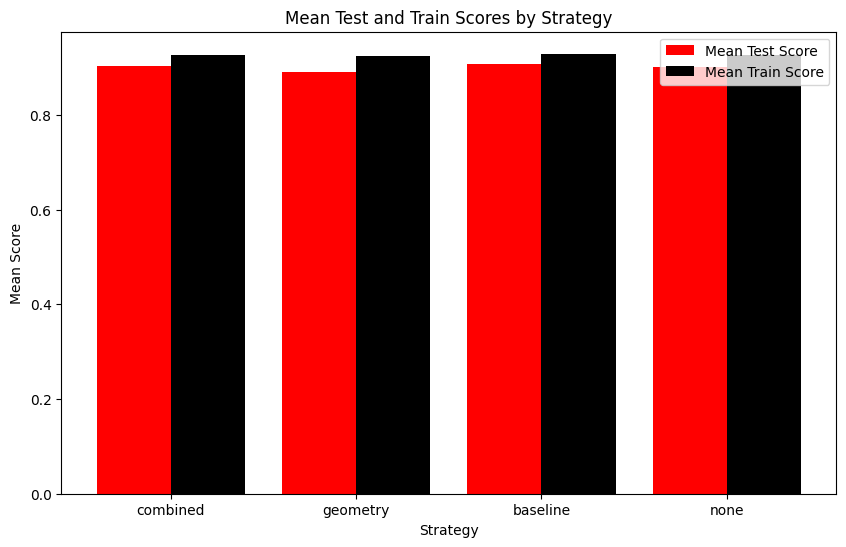

In [57]:
# Calculate mean test and train scores for each split
mean_test_scores = [np.mean(grid_search.cv_results_[f'split{i}_test_score']) for i in range(4)]
mean_train_scores = [np.mean(grid_search.cv_results_[f'split{i}_train_score']) for i in range(4)]

# Strategy names
strategies = grid_search.cv_results_['param_image_mask__strategy']

# Plot bar chart for mean scores
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(strategies)) - 0.2, mean_test_scores, width=0.4, label='Mean Test Score', color='red')
plt.bar(np.arange(len(strategies)) + 0.2, mean_train_scores, width=0.4, label='Mean Train Score', color='black')
plt.xticks(np.arange(len(strategies)), strategies)
plt.xlabel('Strategy')
plt.ylabel('Mean Score')
plt.title('Mean Test and Train Scores by Strategy')
plt.legend()
plt.show()

In [58]:
grid_search.cv_results_

{'mean_fit_time': array([1.38433418, 1.20120916, 1.34426775, 1.19715061]),
 'std_fit_time': array([0.11725251, 0.03118301, 0.1967119 , 0.02560268]),
 'mean_score_time': array([1.94177823, 1.74127831, 1.85333614, 1.7498075 ]),
 'std_score_time': array([0.35383828, 0.02579629, 0.11528637, 0.04409655]),
 'param_image_mask__strategy': masked_array(data=['combined', 'geometry', 'baseline', 'none'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'image_mask__strategy': 'combined'},
  {'image_mask__strategy': 'geometry'},
  {'image_mask__strategy': 'baseline'},
  {'image_mask__strategy': 'none'}],
 'split0_test_score': array([0.90063694, 0.90573248, 0.90191083, 0.90828025]),
 'split1_test_score': array([0.88025478, 0.89808917, 0.89171975, 0.89426752]),
 'split2_test_score': array([0.90318471, 0.90828025, 0.9044586 , 0.91847134]),
 'split3_test_score': array([0.89795918, 0.89923469, 0.89923469, 0.91071429]),
 'split4_test_score

**As all strategies are pretty similar we keep combined cause it improve recall**

In [60]:
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train_simple, y_train_simple)
y_pred = pipeline.predict(X_test_simple)

# Calculate precision and recall and accuracy
ac = round(grid_search.score(X_test_simple, y_test_simple) * 100, 2)
precision = precision_score(y_test_simple, y_pred)
recall = recall_score(y_test_simple, y_pred)


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")

Randomized search acheived 91.88% Accuracy
Randomized search acheived 0.994314143567875 Recall
Randomized search acheived 0.8871274571972099 Precision


Confusion matrix:
[[ 348  178]
 [   8 1399]]


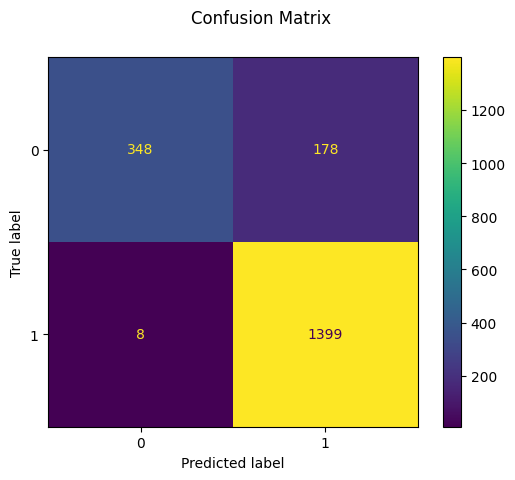

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_simpler = pipeline.predict(X_test_simple)
disp = ConfusionMatrixDisplay.from_predictions(y_test_simple, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

Apparently our intuition were good and the combined mask tends to improve recall

**Trying to create sample values to balance dataset**

In [12]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# Before applying SMOTE
print("Class distribution before SMOTE:")
print("Class 0:", sum(y_simpler == 0))
print("Class 1:", sum(y_simpler == 1))

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_simpler, y_resampled_simpler = smote.fit_resample(X, y_simpler)

# After applying SMOTE
print("\nClass distribution after SMOTE:")
print("Class 0:", sum(y_resampled_simpler == 0))
print("Class 1:", sum(y_resampled_simpler == 1))


Class distribution before SMOTE:
Class 0: 1583
Class 1: 4273

Class distribution after SMOTE:
Class 0: 4273
Class 1: 4273


In [13]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_resampled_simpler, y_resampled_simpler, test_size=0.33, random_state=0)

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train_simple, y_train_simple)
accTrain = round(pipeline.score(X_train_simple, y_train_simple) * 100, 2)
accTest = round(pipeline.score(X_test_simple, y_test_simple) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 95.37% Accuracy - [TrainSet]
Combined mask accuracy is around 93.94% Accuracy - [TestSet]


Confusion matrix:
[[1398   27]
 [ 144 1252]]


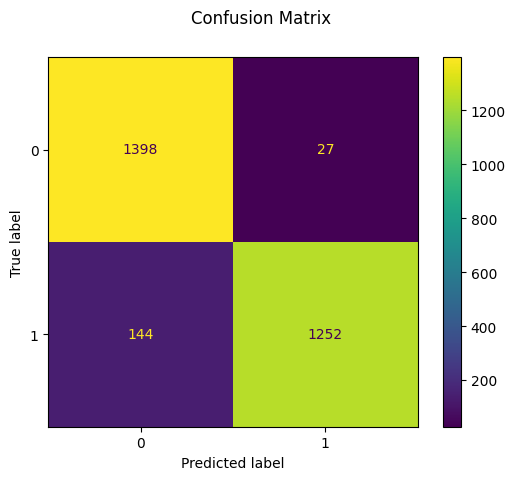

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_simpler = pipeline.predict(X_test_simple)
disp = ConfusionMatrixDisplay.from_predictions(y_test_simple, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

### **Remarkable accuracy but recall is worse and the model is making a lot of false positive**

So, as long as our objective is to trigger warnings on pneumonia we prefer a less accurate model with very few false positive. We won't use balancing data strategy

In [14]:
from sklearn.model_selection import train_test_split

#Get back with unbalanced data

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X, y_simpler, test_size=0.33, random_state=0)

**Important :** Bellow you can see that we evaluate final accuracy on unseen data because even if we used cross-validation we provided only 77% of the dataset to keep completly fresh eye on final result

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from local_lib.mask_transformer import MaskSeuilTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('knn', KNeighborsClassifier())
])

param_grid = {
              'knn__n_neighbors': [3, 5, 8, 10, 13]
              }

grid_search = GridSearchCV(
                    pipeline,
                    param_grid=param_grid,
                    cv=5,
                    n_jobs=8,
                    scoring='recall').fit(X_train_simple, y_train_simple)

ac = round(grid_search.score(X_test_simple, y_test_simple) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
grid_search.best_params_

Randomized search acheived 98.8% Accuracy


{'knn__n_neighbors': 13}

**n_neighbors: 13 and image_mask: combined seems to work well**

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from local_lib.testerTransformer import TesterTransformer
from sklearn.model_selection import GridSearchCV
from local_lib.mask_transformer import MaskSeuilTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('tester_tr', TesterTransformer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

param_grid = {
              'tester_tr__strategy' : ["StandardScaler","MinMaxScaler","Normalizer", "None"]
              }

grid_search = GridSearchCV(
                    pipeline,
                    param_grid=param_grid,
                    cv=5,
                    scoring='recall').fit(X_train_simple, y_train_simple)


ac = round(grid_search.score(X_test_simple, y_test_simple) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
grid_search.best_params_

Randomized search acheived 99.36% Accuracy


{'tester_tr__strategy': 'Normalizer'}

In [11]:
grid_search.cv_results_

{'mean_fit_time': array([3.00539255, 2.15694113, 1.71755753, 1.65835738]),
 'std_fit_time': array([0.14813906, 0.03881654, 0.08113853, 0.0169723 ]),
 'mean_score_time': array([1.74462566, 1.5821239 , 1.41426277, 1.38018732]),
 'std_score_time': array([0.16702709, 0.04846738, 0.03099989, 0.0214341 ]),
 'param_tester_tr__strategy': masked_array(data=['StandardScaler', 'MinMaxScaler', 'Normalizer', 'None'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'tester_tr__strategy': 'StandardScaler'},
  {'tester_tr__strategy': 'MinMaxScaler'},
  {'tester_tr__strategy': 'Normalizer'},
  {'tester_tr__strategy': 'None'}],
 'split0_test_score': array([0.9877836, 0.9895288, 0.9895288, 0.9895288]),
 'split1_test_score': array([0.9930192, 0.9930192, 0.9947644, 0.9947644]),
 'split2_test_score': array([0.9965096, 0.991274 , 0.9982548, 0.9982548]),
 'split3_test_score': array([0.99300699, 0.98601399, 0.99475524, 0.99475524]),
 'split4_tes

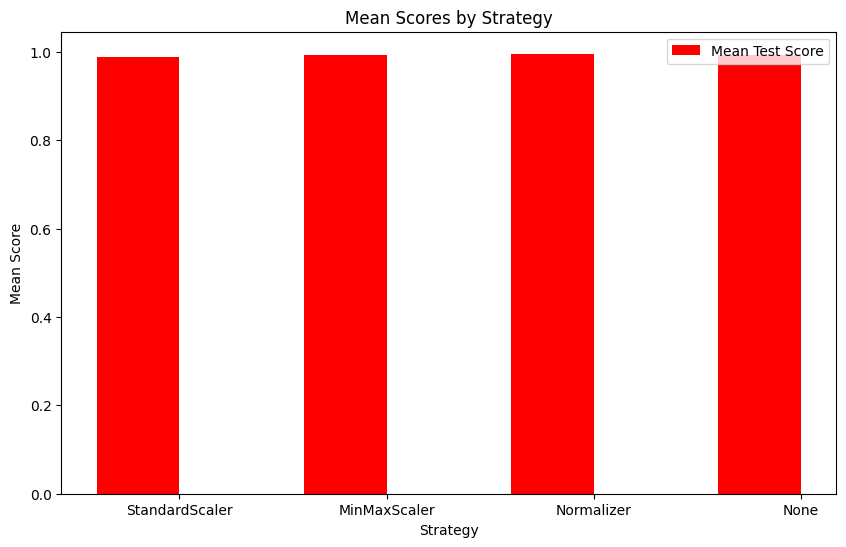

In [21]:
import matplotlib.pyplot as plt

# Calculate mean test and train scores for each split
mean_test_scores = [np.mean(grid_search.cv_results_[f'split{i}_test_score']) for i in range(4)]

# Strategy names
strategies = grid_search.cv_results_['param_tester_tr__strategy']

# Plot bar chart for mean scores
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(strategies)) - 0.2, mean_test_scores, width=0.4, label='Mean Test Score', color='red')
plt.xticks(np.arange(len(strategies)), strategies)
plt.xlabel('Strategy')
plt.ylabel('Mean Score')
plt.title('Mean Scores by Strategy')
plt.legend()
plt.show()

**Normalizer seems to improve recall a bit, but in general they all tends to improve except standardScaler**

Displaying learning curve, recall and precision

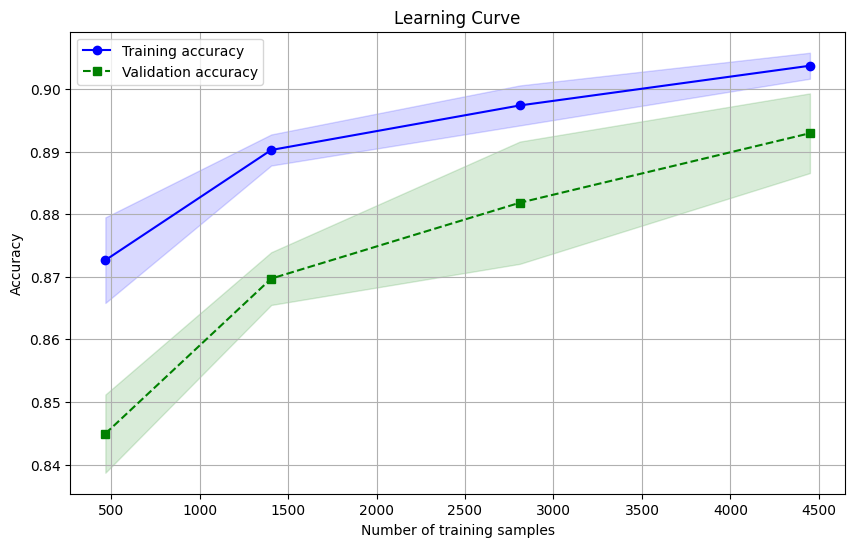

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

# Define your pipeline
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('normalizer', Normalizer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

# Plot learning curves for the best parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X,
    y=y_simpler,
    train_sizes=[0.1, 0.3, 0.6, 0.95],
    n_jobs=8,
    scoring='accuracy',
    random_state=42
)

# Calculate mean and standard deviation of training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### **Clearly our model is not overfitting**

Thought, we can see that the accuracy is not at its prime values since we already experienced 95% accuracy.
Bellow see why this approach is more suitable to this specific medical problematic

In [24]:
from sklearn.model_selection import cross_val_score

# Calculate accuracy, precision and recall using cross validation
precision = cross_val_score(pipeline, X, y_simpler, cv=5, scoring='precision')
recall = cross_val_score(pipeline, X, y_simpler, cv=5, scoring='recall')
accuracy = cross_val_score(pipeline, X, y_simpler, cv=5, scoring='accuracy')

print("vvv Mean scores vvv:")
print("Precision:", precision.mean())
print("Recall:", recall.mean())
print("Accuracy:", accuracy.mean())


vvv Mean scores vvv:
Precision: 0.8766863586734926
Recall: 0.9927452511059067
Accuracy: 0.8927578598846411


Confusion matrix:
[[ 319  204]
 [   9 1401]]


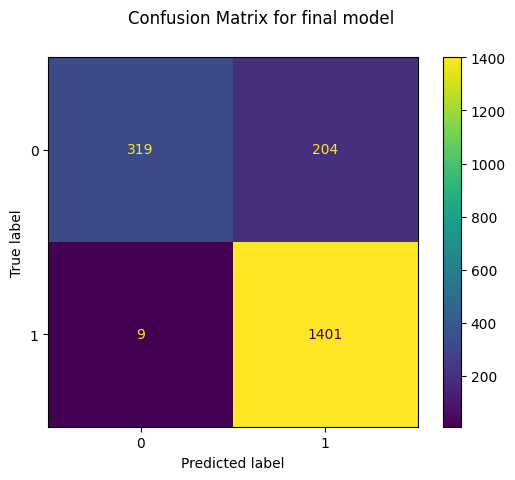

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
pipeline.fit(X_train_simple, y_train_simple)
y_pred_simpler = pipeline.predict(X_test_simple)
disp = ConfusionMatrixDisplay.from_predictions(y_test_simple, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix for final model")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

### Recap:
 - 89.2% accuracy
 - 87.6% precision
 - 99.2% recall
 - homogeneous confusion matrix
 - coherent learning curve

### Recap:
We could have a more accurate model (see the 95% with combined mask and 5 neighbors and resampled data), but if we did that we would have get 144 out of ~1900 test values instead of **9** with our most advanced model